# How to characterize a Sun-like star using asteroseismology?

The bright star named *KIC 10963064* is a solar-like, main sequence star that was observed by NASA's Kepler spacecraft between 2009 and 2013. Because the object is fairly bright (9th magnitude), and because Kepler observed it in its high-cadence mode (1 minute exposures), the Kepler data for this object is of extremely high quality.

The quality of the data is so good, in fact, that it can be used to study the minor brightness fluctuations in the star which are caused by sound waves propagating through the star's atmosphere. The study of such oscillations can reveal the mass, size, and internal structure of a star using a technique which astronomers call [asteroseismology](https://en.wikipedia.org/wiki/Asteroseismology).

This tutorial will demonstrate how the Lightkurve Python package can be used to carry out a quick-look asteroseismic analysis of the star in five easy steps:

1. Downloading the data
2. Cleaning the light curve
3. Plotting a Lomb Scargle periodogram
4. Estimating asteroseismic quantities ($\Delta\nu$, $\nu_{\rm max}$)
5. Estimating stellar parameters (mass, radius, surface gravity)

## 1. Downloading the data

We'll start by searching Kepler's public data archive hosted by MAST for files which contain the short-cadence light curves recorded by Kepler:

In [1]:
import lightkurve as lk

In [2]:
search = lk.search_lightcurvefile('KIC10963065', cadence='short', mission='Kepler')
print(search)

SearchResult containing 27 data products.

 target_name            productFilename                        description              distance
------------- ------------------------------------ ------------------------------------ --------
kplr010963065 kplr010963065-2009259162342_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr010963065 kplr010963065-2010111051353_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010140023957_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010174090439_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010203174610_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010234115140_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010265121752_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010296114515_slc.fits  Lightcurve Short Cadence (CSC) -

It looks like the target was observed in Kepler's Quarters 2 through 17. We'll only download the data for Quarters 5 through 7 to make this tutorial faster to run, but everything we'll do below should work with the full data set as well!

In [3]:
files = search[1:10].download_all()
files

LightCurveFileCollection of 9 objects:
	KIC 10963065 (9 KeplerLightCurveFiles) Quarters: 5,5,5,6,6,6,7,7,7

The data is now available to us as a `LightCurveFileCollection` object, which groups a number of light curve files.

Lightkurve provides a convenience method to extract the recommended `PDCSAP_FLUX` light curve from each file, and stitch them together into a single `LightCurve` object:

In [4]:
lc = files.PDCSAP_FLUX.stitch()

## 2. Cleaning the light curve

Next, let's inspect our time series by plotting the data:

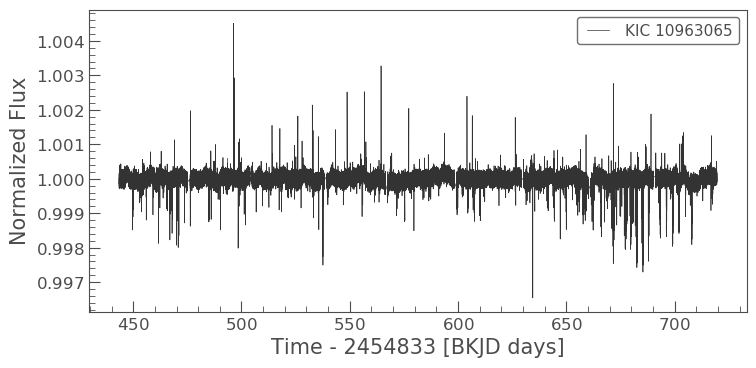

In [5]:
lc.plot();

The light curve looks a bit messy due to the presence of outliers.  This can be explained by a variety of detector effects (e.g. cosmic rays).  Discussing these outliers is the topic of a different tutorial.  For now, let's tidy the light curve by removing the outliers and NaN values:

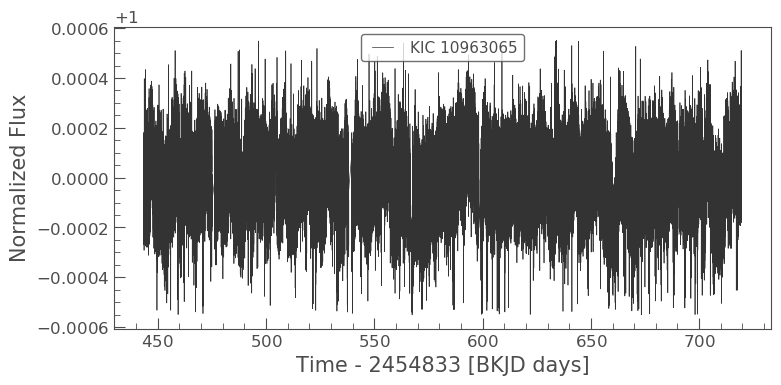

In [6]:
lc = lc.remove_outliers().remove_nans()
lc.plot();

That looks better!

## 3. Plotting a Lomb Scargle periodogram

Next, we'll carry out a Lomb Scargle Periodogram analysis on the light curve.

Note that astronomers who study solar-like oscillations tend to prefer a periodogram to use units of "power spectral density" (psd), which simply means that the X-axis will show frequency units in $\mu Hz$ and the Y-axis will show units in power density instead of amplitude. (Hint: give `normalization = 'amplitude'` a try to see a different type of normalization.)

In [7]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd')

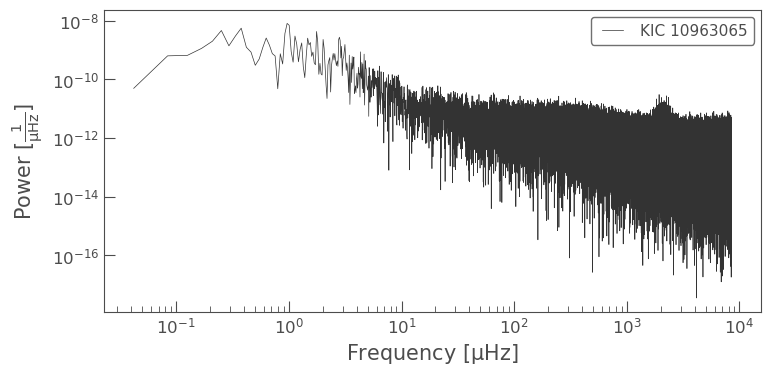

In [8]:
pg.plot(scale='log');

The figure shown above is often called a *power spectrum*, and the bump near $2000\, \mu \rm Hz$ is called a *power excess*.

Let's take a closer look at the area near the *power excess*. For this, we can use the `minimum_frequency` and `maximum_frequency` keywords. This truncates the frequency range evaluated when performing the Lomb Scargle transformation.

(Hint: you can also set `minimum_period` and `maximum_period` if you prefer using periods instead of frequencies!)

In [9]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                       minimum_frequency=1000, maximum_frequency=3000)

To get a better look at the data, we'll also plot a smoothed periodogram over the top using the periodogram's `smooth()` method.

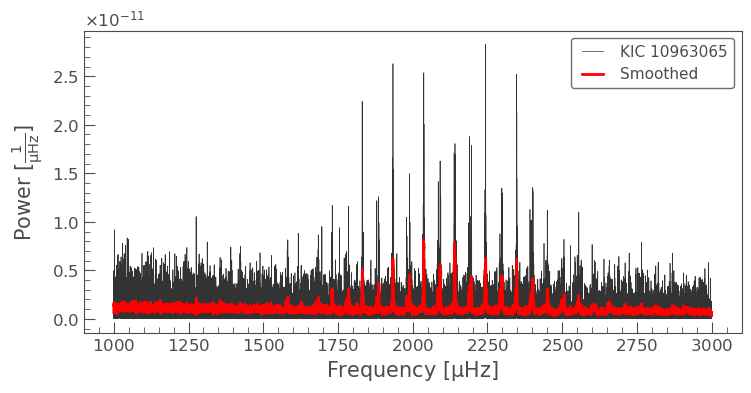

In [10]:
ax = pg.plot()
pg.smooth(method='boxkernel', filter_width=1.).plot(ax=ax, label='Smoothed', c='red', lw=2);

An important measurement in asteroseismology is the central frequency of the power peaks, which is often denoted as $\nu_{\rm max}$ (pronounced "nu max").

A very easy (but somewhat inaccurate) estimators for this quantity is the frequency of the highest peak in the periodogram. For convenience, you can easily obtain the highest peak in a periodogram object using its `frequency_at_max_power` property:

In [11]:
pg.frequency_at_max_power

<Quantity 2244.03210954 uHz>

The highest peak is located near $2244 \mu Hz$. 

You can also use the `show_properties()` method to inspect this and all other properties of the periodogram object:

In [12]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description    Units 
---------------------- -------------- -------
                nterms              1        
              targetid       10963065        
          default_view      frequency        
                 label   KIC 10963065        
             ls_method           fast        
frequency_at_max_power      2244.0321     uHz
             max_power            0.0 1 / uHz
               nyquist      8496.4268     uHz
   period_at_max_power         0.0004 1 / uHz
             frequency array (47707,)     uHz
                period array (47707,) 1 / uHz
                 power array (47707,) 1 / uHz
                  meta <class 'dict'>        


The value of `pg.frequency_at_max_power` is not suitable for a proper asteroseismic analysis however, because the properties of a star scale with the center of the envelope that surrounds the peaks in the power spectrum, rather than the frequency of the maximum peak.  We can see that  `pg.frequency_at_max_power` is offset from the center of power:

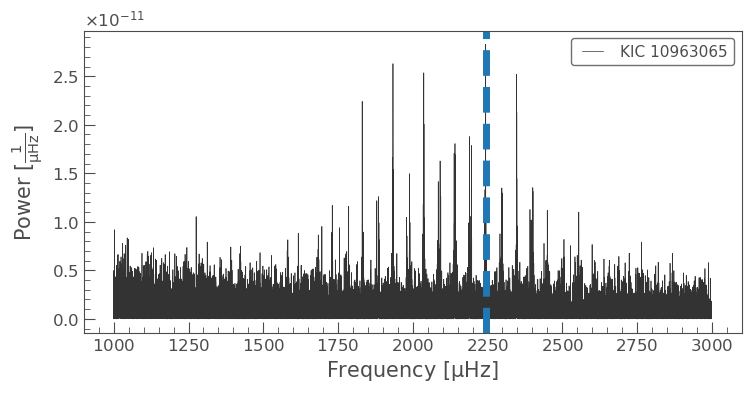

In [13]:
ax = pg.plot()
ax.axvline(pg.frequency_at_max_power.value, lw=5, ls='dashed');

We will improve our estimate of $\nu_{\rm max}$ next.

## 4. Estimating asteroseismic quantities ($\nu_{\rm max}$, $\Delta\nu$)

The first step towards estimating $\nu_{\rm max}$ and $\Delta\nu$ is to remove the background from the periodogram, so that we obtain a Signal-to-Noise (SNR) spectrum. This will prevent our analysis from being confused by low-frequency noise.

Lightkurve provides a fairly primitive flattening tool for quicklook analyses.  More advanced pipelines exist which e.g. offer the user to fit the granulation background in a more careful way.

The `flatten()` method returns a `SNRPeriodogram`. This behaves in the same way as a regular `LombScarglePeriodogram`, except the power is now a unitless signal-to-noise ratio.

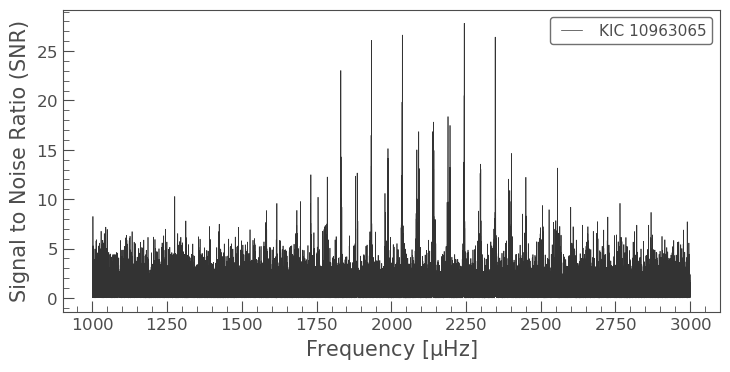

In [14]:
snr = pg.flatten()
snr.plot();

From this periodogram, we can create a `Seismology` helper object which will enable us to extract interesting quantities from the periodogram:

In [15]:
seis = snr.to_seismology()
seis

Seismology(ID: KIC 10963065) - no values have been computed so far.

You can see that seismology is letting us know no values have been estimates so far.

The `Seismology` class provides an `estimate_numax()` method which uses an Autocorrelation Function (following the techniques in Viani et al. 2019) to find where the power excess is highest in a shape approximately close to what we would expect for a solar-like oscillator's modes.

In [16]:
numax = seis.estimate_numax()
numax

numax: 2175.00 uHz (method: ACF2D)

It is not wise to trust the value returned by this method blindly. Fortunately, we have the option to verify the accuracy of the estimate using the `diagnose_numax()` method, which returns a set of diagnostic plots:

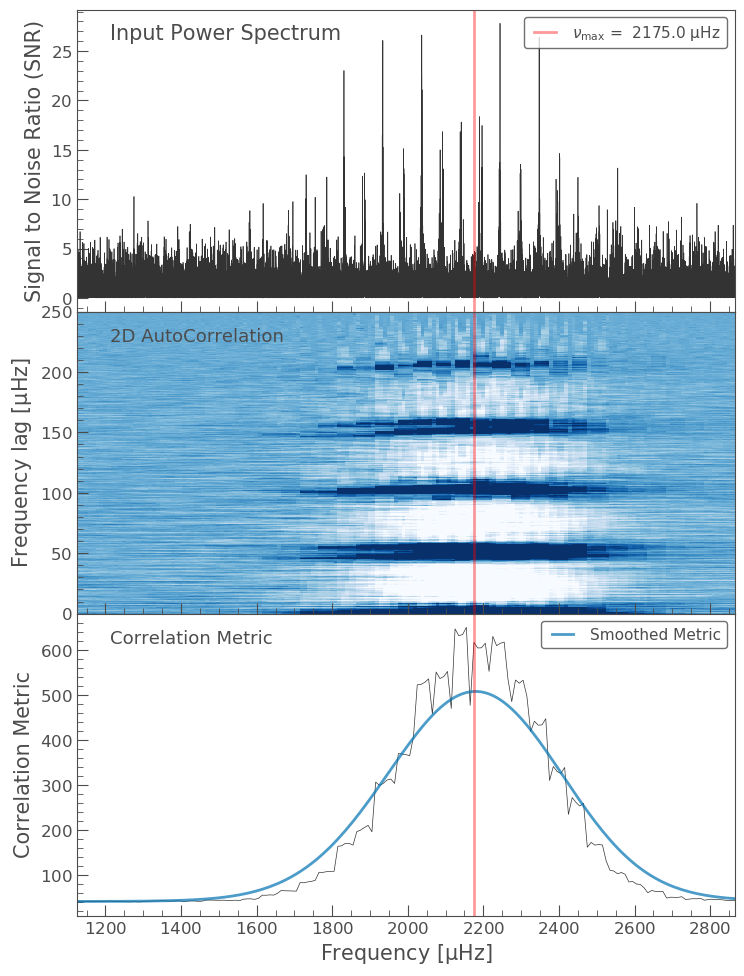

In [17]:
seis.diagnose_numax();

These diagnostic plots suggest that the 2D autocorrelation method returned a reasonable estimate for $\nu_{\rm max}$. At time of writing, Lightkurve does not yet return uncertainties on these values. This may change in the future!

The next step is finding $\Delta\nu$. This also uses an autocorrelation method, but increases the width of the window so it covers the whole mode envelope.

Passing in the $\nu_{\rm max}$ autocorrelates a region approximately equivalent to the spread of the seismic mode envelope. Because this is where the p-modes reside, the resulting function should show neatly spaced peaks at a frequency lag equal to $\Delta\nu$. Seismology stores all its calculated values. You can pass a numax into this function, but ideally we'll want to have run `.estimate_numax()` first.

We estimate the $\Delta\nu$ first, and then have a look at the diagnostics:

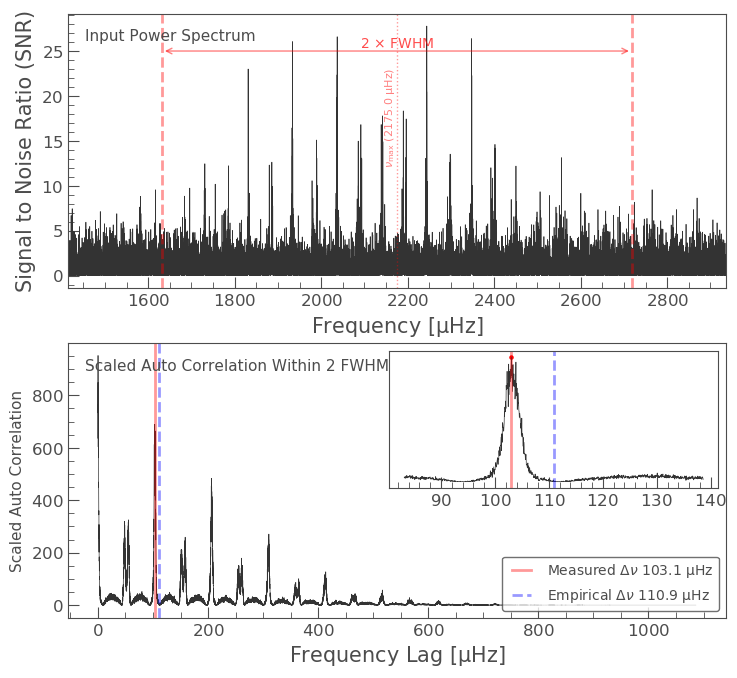

In [18]:
deltanu = seis.estimate_deltanu()
ax = seis.diagnose_deltanu();

That looks sensible. More advanced mode-fitting pipelines will likely be able to do slightly better, but this is a good first-look result.

The real hallmark of a good $\Delta\nu$ estimate is that it produces a nice echelle diagram. All periodogram objects have access to the `plot_echelle()` method, which only requires a $\Delta\nu$. If we pass it a $\nu_{\rm max}$ too, it just shows the area around the seismic mode envelope we care about!

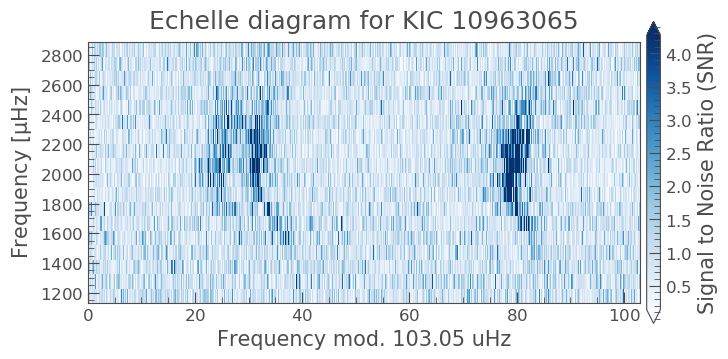

In [19]:
seis.plot_echelle();

If you prefer to smooth your echelle diagrams a little, we can do so using the `smooth_filter_width` kwarg, which calls `seismology.periodogram.smooth(filter_width=smooth_filter_width)` internally. We can also play around with the plotting keywords a little, to make it more visible.

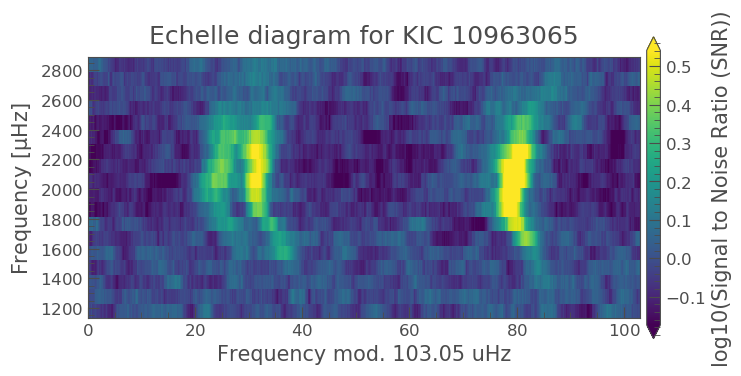

In [20]:
seis.plot_echelle(smooth_filter_width=3., scale='log', cmap='viridis');

Thanks to the high signal-to-noise of these data, you can see the radial, dipole, and quadrupole modes clearly in the spectrum, including slight curvature in the mode frequencies.

If we have a look at the Seismology module now, we'll notice it's holding on to our estimated $\nu_{\rm max}$ and $\Delta\nu$ values! We can recover them as attributes of seismology:

In [21]:
print(seis)
seis.deltanu

Seismology(ID: KIC 10963065) - computed values:
 * numax: 2175.00 uHz (method: ACF2D)
 * deltanu: 103.05 uHz (method: ACF2D)


deltanu: 103.05 uHz (method: ACF2D)

Finally, let's use these asteroseismic quantities to estimate the stellar parameters of the target star.

## 5. Estimating stellar parameters (mass, radius, surface gravity)

Lightkurve provides easy access to basis asteroseismic scaling relationships. This comes with a few caveats, e.g. uncertainties are not supported at this time, and Lightkurve is not not equipped (yet) to deal with corrections to the scaling relations that are required to get accurate stellar parameters for more evolved stars.

Using the values reported in the Asteroseismic Modelling Portal (AMP) reported in [Mathur et al. 2012](https://arxiv.org/abs/1202.2844), we know the temperature of our target to be $T_{\rm eff} = 6046\, K$, and we have pre-exiting literature values available:

In [22]:
Teff = 6046
trueradius = 1.20
truemass = 1.03
truelogg = 4.29

Here is how we can approach these values using Lightkurve's built-in scaling relations:

In [23]:
mass = seis.estimate_mass(Teff)
mass

mass: 1.10 solMass (method: Uncorrected Scaling Relations)

We can do the same again for radius and surface gravity.

In [24]:
radius = seis.estimate_radius(Teff)
radius

radius: 1.24 solRad (method: Uncorrected Scaling Relations)

In [25]:
logg = seis.estimate_logg(Teff)
logg

logg: 4.30 dex (method: Uncorrected Scaling Relations)

The literature values for these are:

In [26]:
print('Radius : {} vs {:.2f} Rsol'.format(trueradius, radius.value))
print('Mass : {} vs {:.2f} Msol'.format(truemass, mass.value))
print('logg : {} vs {:.2f} dex'.format(truelogg, logg.value))

Radius : 1.2 vs 1.24 Rsol
Mass : 1.03 vs 1.10 Msol
logg : 4.29 vs 4.30 dex


That's a good match!

This ends this tutorial on Lightkurve's suite of asteroseismology tools. We hope it will make quick-look asteroseismic analyses more accessible!